# Extracting Time-Series for Analysis

<br>

### Imports

In [1]:
from satip import io

import shapely
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

C:\Users\Ayrto\anaconda3\envs\satip_dev\lib\site-packages\google\auth\_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
Downloading: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68rows/s]


<br>

### User Inputs

We have to specify the bucket where the data is located

In [4]:
zarr_bucket = 'solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/zarr_full_extent_TM_int16'

<br>

### Loading Data

Then the `satip` wrapper for loading data will generate an `xarray` `Dataset`

In [6]:
ds = io.load_from_zarr_bucket(zarr_bucket)

ds

,Array,Chunk
Bytes,958.33 GB,246.53 MB
Shape,"(11662, 1870, 1831, 12)","(36, 1870, 1831, 1)"
Count,3889 Tasks,3888 Chunks
Type,int16,numpy.ndarray


<br>

We can then index this as we would any other `xarray` object

In [7]:
da_HRV_sample = ds['stacked_eumetsat_data'].isel(time=slice(800, 900)).sel(variable='HRV')

da_HRV_sample

<xarray.DataArray 'stacked_eumetsat_data' (time: 100, x: 1870, y: 1831)>
dask.array<getitem, shape=(100, 1870, 1831), dtype=int16, chunksize=(36, 1870, 1831), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 2020-01-03T12:49:15 ... 2020-01-03T21:04:16
    variable  <U3 'HRV'
  * x         (x) float64 -3.088e+06 -3.084e+06 ... 4.384e+06 4.388e+06
  * y         (y) float64 9.012e+06 9.008e+06 9.004e+06 ... 1.696e+06 1.692e+06
Attributes:
    meta:     {'orbital_parameters': {'projection_longitude': 9.5, 'projectio...

<br>

### Extracting Time-Series

The coordinates are for a Transverse Mercator projection, we'll create a helper function that converts latitude and longitude into this coordinate system

In [8]:
def convert_lon_lat_to_crs_coords(lon=0.1, lat=51.5):
    new_coords_point = (gpd.GeoDataFrame(geometry=[shapely.geometry.Point(lon, lat)], crs='EPSG:4326')
                        .to_crs('EPSG:3857')
                        .loc[0, 'geometry'])
    
    new_coords = (new_coords_point.x, new_coords_point.y)
    
    return new_coords

x, y = convert_lon_lat_to_crs_coords(lon=1, lat=50)

x, y

(111319.49079327357, 6446275.841017158)

<br>

We'll now interpolate the data at this location and extract a time-series of the HRV intensity

C:\Users\Ayrto\anaconda3\envs\satip_dev\lib\site-packages\xarray\core\indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<AxesSubplot:xlabel='time'>

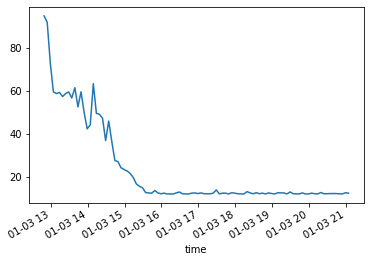

In [9]:
s_HRV = da_HRV_sample.interp(x=x, y=y).sortby('time').to_series()

s_HRV.plot()

<br>

We can also visualise the intensity distribution for this series

<AxesSubplot:xlabel='stacked_eumetsat_data', ylabel='Count'>

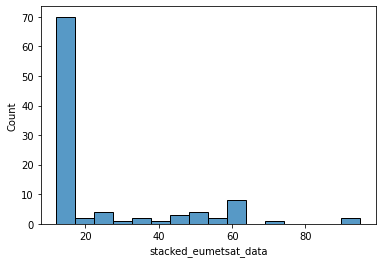

In [10]:
sns.histplot(s_HRV)